In [1]:
import dgl
import pathlib
import os
import numpy as np
from dgl.data import DGLDataset
from dgl.data.utils import download, extract_archive, _get_dgl_url
from dgl.convert import graph as dgl_graph
from dgl import backend as F

''' rkdit package for processing moleculars '''
import rdkit
from rdkit import Chem
from rdkit.Chem.rdchem import HybridizationType
from rdkit.Chem.rdchem import BondType as BT
from rdkit import RDLogger

RDLogger.DisableLog('rdApp.*')

Using backend: pytorch[16:39:45] /tmp/dgl_src/src/runtime/tensordispatch.cc:43: TensorDispatcher: dlopen failed: dlopen(/Users/nisarg/opt/anaconda3/envs/se3_transformer/lib/python3.9/site-packages/dgl/tensoradapter/pytorch/libtensoradapter_pytorch_1.10.2.dylib, 1): image not found



In [2]:
HAR2EV = 27.2113825435      # 1 Hartree = 27.2114 eV 
KCALMOL2EV = 0.04336414     # 1 kcal/mol = 0.043363 eV
conversion = F.tensor([
    1., 1., HAR2EV, HAR2EV, HAR2EV, 1., HAR2EV, HAR2EV, HAR2EV, HAR2EV, HAR2EV,
    1., KCALMOL2EV, KCALMOL2EV, KCALMOL2EV, KCALMOL2EV, 1., 1., 1.
])


In [3]:
raw_dir = 'data'
raw_url = 'https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/molnet_publish/qm9.zip'
raw_url2 = 'https://ndownloader.figshare.com/files/3195404'

In [4]:
keys = ['mu', 'alpha', 'homo', 'lumo', 'gap', 'r2', 'zpve', 'U0', 'U', 'H', 'G', 'Cv', 'U0_atom',
            'U_atom', 'H_atom', 'G_atom', 'A', 'B', 'C']

In [5]:
types = {'H': 0, 'C': 1, 'N': 2, 'O': 3, 'F': 4}

In [6]:
bonds = {BT.SINGLE: 0, BT.DOUBLE: 1, BT.TRIPLE: 2, BT.AROMATIC: 3}

In [7]:
if not os.path.exists(f'{raw_dir}/gdb9.sdf.csv'):
    file_path = download(raw_url, raw_dir)
    extract_archive(file_path, raw_dir, overwrite=True)
    os.unlink(file_path)

In [15]:
if not os.path.exists(f'{raw_dir}/uncharacterized.txt'):
    file_path = download(raw_url2, raw_dir)
    os.replace(f'{raw_dir}/3195404', f'{raw_dir}/uncharacterized.txt')

In [20]:
with open(f'{raw_dir}/gdb9.sdf.csv', 'r') as f:
    target = f.read().split('\n')[1:-1]

In [23]:
target[0]

'gdb_1,157.7118,157.70997,157.70699,0,13.21,-0.3877,0.1171,0.5048,35.3641,0.044749,-40.47893,-40.476062,-40.475117,-40.498597,6.469,-395.999594594,-398.643290011,-401.014646522,-372.471772148'

In [24]:
target = [[float(x) for x in line.split(',')[1:20]] for line in target]

In [27]:
target = F.tensor(target, dtype=F.data_type_dict['float32'])

In [29]:
target = F.cat([target[:, 3:], target[:, :3]], dim=-1)

In [37]:
target = (target * conversion.view(1, -1)).tolist()

In [48]:
with open(f'{raw_dir}/uncharacterized.txt', 'r') as f:
        skip = [int(x.split()[0]) - 1 for x in f.read().split('\n')[9:-2]]

In [50]:
suppl = Chem.SDMolSupplier(f'{raw_dir}/gdb9.sdf', removeHs=False, sanitize=False)

In [56]:
n_node = []
n_edge = []
node_pos = []
node_attr = []

src = []
dst = []

edge_attr = []
targets = []

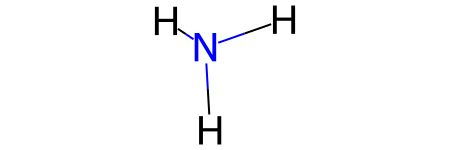

In [66]:
suppl[1]

In [67]:
suppl[1].GetNumAtoms()

4

In [69]:
suppl.GetItemText(1)

'gdb_2\n  -OEChem-03231823233D\n\n  4  3  0     0  0  0  0  0  0999 V2000\n   -0.0404    1.0241    0.0626 N   0  0  0  0  0  0  0  0  0  0  0  0\n    0.0173    0.0125   -0.0274 H   0  0  0  0  0  0  0  0  0  0  0  0\n    0.9158    1.3587   -0.0288 H   0  0  0  0  0  0  0  0  0  0  0  0\n   -0.5203    1.3435   -0.7755 H   0  0  0  0  0  0  0  0  0  0  0  0\n  1  2  1  0  0  0  0\n  1  3  1  0  0  0  0\n  1  4  1  0  0  0  0\nM  END\n$$$$\n'

In [71]:
pos = suppl.GetItemText(1).split('\n')[4:4 + 4]

In [72]:
pos

['   -0.0404    1.0241    0.0626 N   0  0  0  0  0  0  0  0  0  0  0  0',
 '    0.0173    0.0125   -0.0274 H   0  0  0  0  0  0  0  0  0  0  0  0',
 '    0.9158    1.3587   -0.0288 H   0  0  0  0  0  0  0  0  0  0  0  0',
 '   -0.5203    1.3435   -0.7755 H   0  0  0  0  0  0  0  0  0  0  0  0']

In [73]:
pos = [[float(x) for x in line.split()[:3]] for line in pos]

In [74]:
pos

[[-0.0404, 1.0241, 0.0626],
 [0.0173, 0.0125, -0.0274],
 [0.9158, 1.3587, -0.0288],
 [-0.5203, 1.3435, -0.7755]]

In [76]:
len(suppl[1].GetAtoms())

4

In [90]:
row, col, edge_type = [], [], []
for bond in suppl[1].GetBonds():
    start, end = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
    row += [start, end]
    col += [end, start]
    edge_type += 2 * [bonds[bond.GetBondType()]]

In [91]:
row

[0, 1, 0, 2, 0, 3]

In [92]:
col

[1, 0, 2, 0, 3, 0]

In [93]:
edge_type

[0, 0, 0, 0, 0, 0]

In [94]:
edge_index = np.array([row, col]).astype(np.int64)
edge_type = np.array(edge_type).astype(np.int64)
edge_feat = np.eye(len(bonds))[edge_type]

In [95]:
edge_index

array([[0, 1, 0, 2, 0, 3],
       [1, 0, 2, 0, 3, 0]])

In [97]:
edge_feat

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]])

In [98]:
perm = (edge_index[0] * n_atom + edge_index[1]).argsort()
edge_index = edge_index[:, perm]
edge_feat = edge_feat[perm]

In [99]:
perm

array([0, 2, 4, 1, 3, 5])

In [101]:
edge_feat

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]])